In [1]:
import os
import cv2
import math
import time
import torch
import random
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
from math import sqrt
from tqdm import tqdm
from pathlib import Path
import torch.optim as optim
import torch.optim as optim
from torchinfo import summary
from datetime import timedelta
from functools import lru_cache
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    matthews_corrcoef, confusion_matrix, classification_report
)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
dataset = Path(r"/kaggle/input/")
covid_19 = dataset / "covid19-radiography-database" / "COVID-19_Radiography_Dataset"
chest_xray = dataset / "chest-xray-pneumonia" / "chest_xray"
tb_chest = dataset / "tuberculosis-tb-chest-xray-dataset" / "TB_Chest_Radiography_Database"

In [4]:
class_mapping = defaultdict(list)

def append_file_names(directory, cls_name):
    """
    Append file names from a given directory to the corresponding class in the class_mapping dictionary.

    Args:
        directory (str): Directory path.
        cls_name (str): Name of the class.
    """
    for f_name in os.listdir(directory):
        if f_name.endswith((".jpeg", ".png")):
            class_mapping[cls_name].append(os.path.join(directory, f_name))

In [5]:
for covid19_class in [entry.name for entry in os.scandir(covid_19) if entry.is_dir()]:
    append_file_names(covid_19 / f"{covid19_class}" / 'images', f"{covid19_class}")

In [6]:
pneumonia_dirs = [chest_xray / "train" / "PNEUMONIA",
                  chest_xray / "test" / "PNEUMONIA",
                  chest_xray / "val" / "PNEUMONIA"]
for source_dir in pneumonia_dirs:
    for filename in os.listdir(source_dir):
        if filename.endswith(".jpeg"):
            if "bacteria" in filename:
                class_mapping["Bacterial Pneumonia"].append(os.path.join(source_dir, filename))

In [7]:
append_file_names(tb_chest / "Tuberculosis", "Tuberculosis")

In [8]:
class_names = list(class_mapping.keys())
image_paths = []
labels = []

for class_name, file_paths in class_mapping.items():
    for file_path in tqdm(file_paths, desc=f"Processing {class_name}"):
        image_paths.append(file_path)
        labels.append(class_name)

Processing Tuberculosis: 100%|██████████| 700/700 [00:00<00:00, 2671531.21it/s]


In [9]:
def is_black_and_white(image):
    """
    Check if the given image is black and white (grayscale).

    Parameters:
        image (PIL.Image.Image): The image object to check.

    Returns:
        bool: True if the image is black and white, False otherwise.
    """
    return image.mode == 'L'

In [10]:
from concurrent.futures import ThreadPoolExecutor
from PIL import Image

In [11]:
def process_image(image_path, label):
    """
    Process a single image and return the color type.

    Parameters:
        image_path (str): File path of the image.
        label: Class label of the image.

    Returns:
        tuple: A tuple containing the label and color type ('Black & White' or 'Colored').
    """
    with Image.open(image_path) as image:
        color_type = 'Black & White' if is_black_and_white(image) else 'Colored'
    return label, color_type

def count_images_per_class(image_paths, labels):
    """
    Count the number of black and white and colored images per class.

    Parameters:
        image_paths (list): List of file paths of the images.
        labels (list): List of corresponding class labels.

    Returns:
        pandas.DataFrame: DataFrame containing the counts per class in tabular format.
    """
    data = defaultdict(lambda: {'Black & White': 0, 'Colored': 0})

    with ThreadPoolExecutor() as executor:
        processed_results = list(tqdm(executor.map(process_image, image_paths, labels), total=len(image_paths), desc="Processing images"))

    for label, color_type in processed_results:
        data[label][color_type] += 1

    df = pd.DataFrame(data).transpose().reset_index()
    df = df.rename(columns={'index': 'Class'})
    return df

result_df = count_images_per_class(image_paths, labels)
print(result_df)

Processing images: 100%|██████████| 24645/24645 [00:17<00:00, 1417.19it/s]

                 Class  Black & White  Colored
0               Normal          10192        0
1         Lung_Opacity           6012        0
2      Viral Pneumonia           1205      140
3                COVID           3616        0
4  Bacterial Pneumonia           2637      143
5         Tuberculosis            308      392


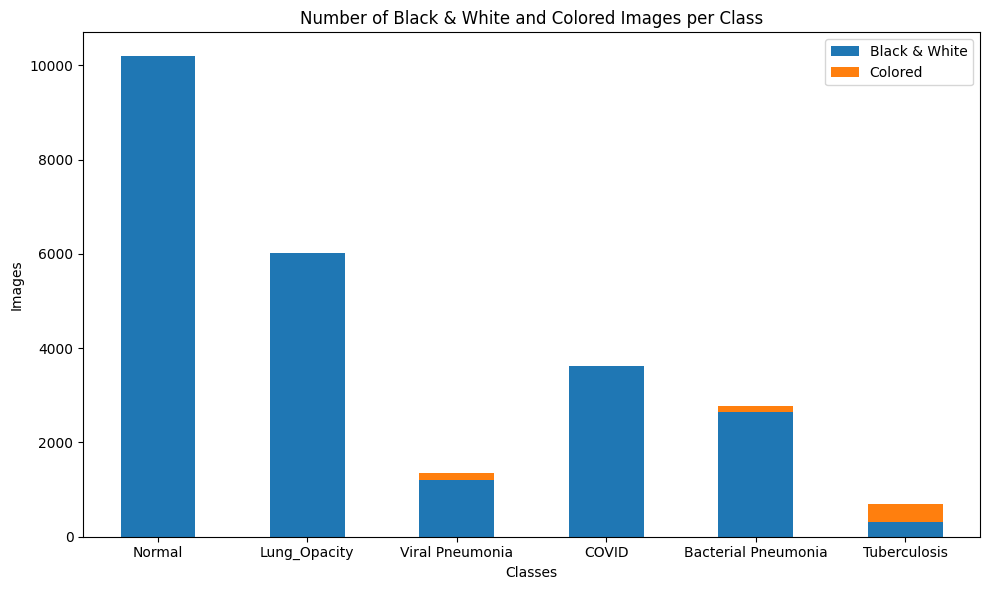

In [12]:
def visualize_images_per_class(result_df, class_column='Class', bw_column='Black & White', colored_column='Colored'):
    """
    Visualize the number of black and white images and colored images per class.

    Parameters:
        result_df (pandas.DataFrame): DataFrame containing the counts per class.
        class_column (str): Name of the column containing the class labels.
        bw_column (str): Name of the column containing the count of black and white images.
        colored_column (str): Name of the column containing the count of colored images.

    Returns:
        None
    """
    result_df.set_index(class_column, inplace=True)

    ax = result_df.plot(kind='bar', stacked=True, figsize=(10, 6), rot=0)
    ax.set_xlabel('Classes')
    ax.set_ylabel('Images')
    ax.set_title('Number of Black & White and Colored Images per Class')
    ax.legend(["Black & White", "Colored"])

    plt.tight_layout()
    plt.show()

visualize_images_per_class(result_df)

Loading and displaying images: 100%|██████████| 6/6 [00:00<00:00, 188.50it/s]


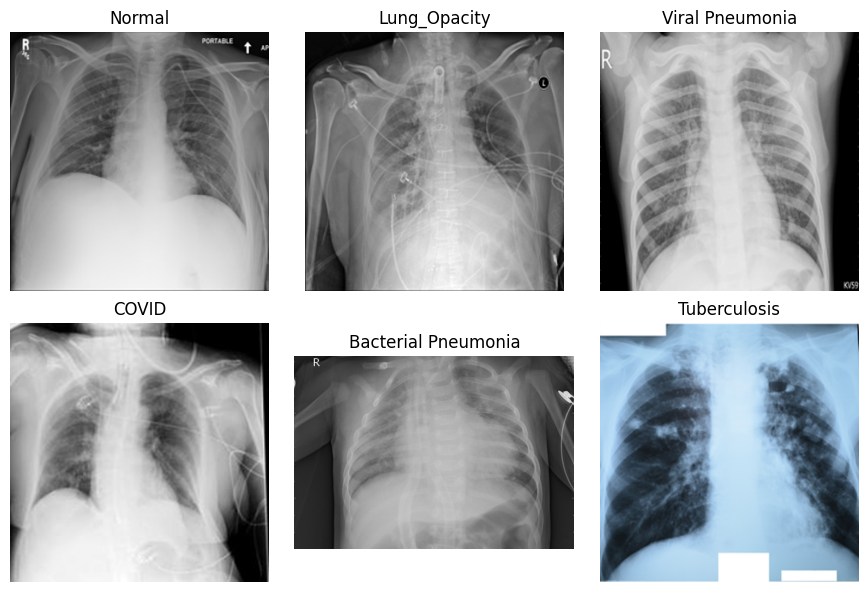

In [13]:
def group_images_by_class(image_paths, labels):
    """
    Group image paths by class label.

    Parameters:
        image_paths (list): List of file paths of the images.
        labels (list): List of corresponding class labels.

    Returns:
        dict: A dictionary where the keys are class labels, and the values are lists of image paths for each class.
    """
    class_to_images = {}
    for img_path, label in zip(image_paths, labels):
        if label not in class_to_images:
            class_to_images[label] = []
        class_to_images[label].append(img_path)
    return class_to_images

def display_images_per_class(image_paths, labels):
    class_to_images = group_images_by_class(image_paths, labels)
    num_classes = len(class_to_images)

    num_rows, num_cols = 1, num_classes
    if num_classes == 4:
        num_rows, num_cols = 2, 2
    elif num_classes == 6:
        num_rows, num_cols = 2, 3

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(3 * num_cols, 3 * num_rows))

    with tqdm(total=num_classes, desc="Loading and displaying images") as pbar:
        for i, (class_label, image_paths_for_class) in enumerate(class_to_images.items()):
            selected_image_path = random.choice(image_paths_for_class)
            try:
                selected_image = Image.open(selected_image_path)
                ax = axs[i // num_cols, i % num_cols]
                ax.imshow(selected_image, cmap='gray')
                ax.set_title(class_label)
                ax.axis('off')
            except Exception as e:
                print(f"Error loading image: {selected_image_path}")
                print(e)

            pbar.update(1)

    plt.tight_layout()
    plt.show()

display_images_per_class(image_paths, labels)

Displaying Images: 100%|██████████| 6/6 [00:17<00:00,  2.87s/it]


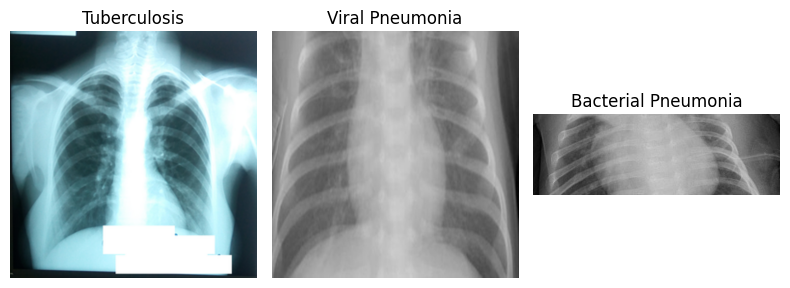

In [14]:
@lru_cache(maxsize=100)
def load_colored_image(image_path):
    """
    Load an image using Pillow and check if it is a colored image (not grayscale).

    Parameters:
        image_path (str): The path to the image file.

    Returns:
        numpy.ndarray or None: The loaded colored image as a NumPy array, or None if grayscale.
    """
    try:
        img = Image.open(image_path)
        if not is_black_and_white(img):
            return np.array(img)
    except (IOError, OSError) as e:
        raise Exception(f"Error loading image '{image_path}': {e}")
    return None

def display_colored_images(image_paths, labels, num_images_per_class=1):
    """
    Randomly display colored images for each class.

    Parameters:
        image_paths (list): List of file paths of the images.
        labels (list): List of corresponding class labels.
        num_images_per_class (int): Number of images to display per class.

    Returns:
        None
    """
    plt.figure(figsize=(8, 6))
    displayed_classes = 0
    unique_labels = set(labels)

    shuffled_labels = list(unique_labels)
    random.shuffle(shuffled_labels)

    for class_label in tqdm(shuffled_labels, desc="Displaying Images"):
        image_paths_for_class = [img_path for img_path, lbl in zip(image_paths, labels) if lbl == class_label]
        colored_images_for_class = [img_path for img_path in image_paths_for_class if load_colored_image(img_path) is not None]

        if len(colored_images_for_class) == 0:
            continue

        num_images_to_display = min(len(colored_images_for_class), num_images_per_class)

        for i in range(num_images_to_display):
            selected_image_path = random.choice(colored_images_for_class)
            selected_image = load_colored_image(selected_image_path)

            displayed_classes += 1
            plt.subplot(2, 3, displayed_classes)
            plt.imshow(selected_image)
            plt.title(f"{class_label}")
            plt.axis('off')

            if displayed_classes == 6:
                break

        if displayed_classes == 6:
            break

    plt.tight_layout()
    plt.show()

display_colored_images(image_paths, labels, num_images_per_class=1)

In [15]:
# Encode the labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
classes = label_encoder.classes_
num_classes = len(classes)

# First: split off the test set (10% of the total)
remaining_paths, test_paths, remaining_labels, test_labels = train_test_split(
    image_paths,
    labels_encoded,
    test_size=0.1,
    random_state=42,
    stratify=labels_encoded
)

# Second: from the remaining 90%, split off the validation set.
# To have validation = 10% of the total, we use test_size = 0.1 / 0.9 ≈ 0.1111 here.
train_paths, val_paths, train_labels, val_labels = train_test_split(
    remaining_paths,
    remaining_labels,
    test_size=0.1111,
    random_state=42,
    stratify=remaining_labels
)

# Calculate total counts and percentages
total_samples = len(labels_encoded)
total_train_samples = len(train_paths)
total_val_samples = len(val_paths)
total_test_samples = len(test_paths)

train_percentage = (total_train_samples / total_samples) * 100
val_percentage = (total_val_samples / total_samples) * 100
test_percentage = (total_test_samples / total_samples) * 100

# Compute class distribution counts for each split
train_counts = pd.Series(train_labels).value_counts().sort_index()
val_counts = pd.Series(val_labels).value_counts().sort_index()
test_counts = pd.Series(test_labels).value_counts().sort_index()

# Create DataFrames for reporting (assuming 'class_names' is defined)
train_df = pd.DataFrame({'Train Samples': train_counts})
val_df = pd.DataFrame({'Validation Samples': val_counts})
test_df = pd.DataFrame({'Test Samples': test_counts})
train_df.index = val_df.index = test_df.index = class_names

# Print summary information
print("Total Train Samples:", total_train_samples)
print("Total Validation Samples:", total_val_samples)
print("Total Test Samples:", total_test_samples)
print("\nPercentage of Split:")
print("Train: {:.2f}%".format(train_percentage))
print("Validation: {:.2f}%".format(val_percentage))
print("Test: {:.2f}%".format(test_percentage))
print("\nClass Distribution:")
result_df = pd.concat([train_df, val_df, test_df], axis=1)
print(result_df)

Total Train Samples: 19715
Total Validation Samples: 2465
Total Test Samples: 2465

Percentage of Split:
Train: 80.00%
Validation: 10.00%
Test: 10.00%

Class Distribution:
                     Train Samples  Validation Samples  Test Samples
Normal                        2224                 278           278
Lung_Opacity                  2892                 362           362
Viral Pneumonia               4810                 601           601
COVID                         8154                1019          1019
Bacterial Pneumonia            560                  70            70
Tuberculosis                  1075                 135           135


In [16]:
class ImageDataset(Dataset):
    def __init__(self, img_paths, img_labels, transform=None):
        """
        Custom Dataset class to load and preprocess images.

        Args:
            img_paths (list): List of image file paths.
            img_labels (list): List of corresponding image labels.
            transform (callable, optional): Transform to apply to images. Defaults to None.
        """
        self.img_paths = img_paths
        self.img_labels = img_labels
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, index):
        img = cv2.imread(str(self.img_paths[index]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        pil_img = Image.fromarray(img)
        
        transformed_img = self.transform(pil_img)

        label = self.img_labels[index]
        return transformed_img, label

In [17]:
BATCH_SIZE = 16

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

train_dataset = ImageDataset(train_paths, train_labels, transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)

val_dataset = ImageDataset(val_paths, val_labels, transform)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=2, pin_memory=True)

test_dataset = ImageDataset(test_paths, test_labels, transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=2, pin_memory=True)

train_steps = len(train_loader)
val_steps = len(val_loader)
test_steps = len(test_loader)

In [18]:
!git clone https://github.com/facebookresearch/ConvNeXt-V2.git
!pip install timm==0.3.2 tensorboardX six
!pip install submitit
!pip install --upgrade timm

Cloning into 'ConvNeXt-V2'...
remote: Enumerating objects: 44, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 44 (delta 10), reused 5 (delta 5), pack-reused 24 (from 1)
Receiving objects: 100% (44/44), 796.52 KiB | 4.50 MiB/s, done.
Resolving deltas: 100% (14/14), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 5.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 5.9 MB/s eta 0:00:00
  Attempting uninstall: timm
    Found existing installation: timm 1.0.20
    Uninstalling timm-1.0.20:
      Successfully uninstalled timm-1.0.20
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 31.1 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: timm
    Found existing installation: timm 0.3.2
    Uninstalling timm-0.3.2:


In [19]:
import timm.data.constants as td_constants
import timm.data
timm.data.OPENAI_CLIP_MEAN = td_constants.OPENAI_CLIP_MEAN
timm.data.OPENAI_CLIP_STD = td_constants.OPENAI_CLIP_STD

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [20]:
%%bash
FILE="/kaggle/working/ConvNeXt-V2/models/utils.py"

if [ -f "$FILE" ]; then
    echo "Modifying $FILE to disable MinkowskiEngine dependency..."
    sed -i.bak 's/^from MinkowskiEngine import SparseTensor/# from MinkowskiEngine import SparseTensor/g' "$FILE"
    echo "Modification complete. A backup was saved as $FILE.bak."
else
    echo "Error: File $FILE not found. Please check your repository structure."
fi

Modifying /kaggle/working/ConvNeXt-V2/models/utils.py to disable MinkowskiEngine dependency...
Modification complete. A backup was saved as /kaggle/working/ConvNeXt-V2/models/utils.py.bak.


In [21]:
import sys
sys.path.append('/kaggle/working/ConvNeXt-V2')
from models.convnextv2 import convnextv2_tiny

/usr/local/lib/python3.12/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [22]:
# Create a ConvNeXt V2 Tiny model (e.g., for 1000-class classification)
model = convnextv2_tiny(num_classes=6, drop_path_rate=0.1, head_init_scale=1.0)
model.to(device)

# Print model architecture summary
summary(model, (1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ConvNeXtV2                               [1, 6]                    --
├─ModuleList: 1-7                        --                        (recursive)
│    └─Sequential: 2-1                   [1, 96, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 96, 56, 56]           4,704
│    │    └─LayerNorm: 3-2               [1, 96, 56, 56]           192
├─ModuleList: 1-8                        --                        (recursive)
│    └─Sequential: 2-2                   [1, 96, 56, 56]           --
│    │    └─Block: 3-3                   [1, 96, 56, 56]           79,968
│    │    └─Block: 3-4                   [1, 96, 56, 56]           79,968
│    │    └─Block: 3-5                   [1, 96, 56, 56]           79,968
├─ModuleList: 1-7                        --                        (recursive)
│    └─Sequential: 2-3                   [1, 192, 28, 28]          --
│    │    └─LayerNorm: 3-6               [

In [23]:
def custom_metrics(y_pred, y_true, loss):
    """
    Calculate custom evaluation metrics for multiclass classification.

    Args:
        y_pred (Tensor): Predicted probabilities for each class.
        y_true (Tensor): True labels.
        loss (float): Loss value.

    Returns:
        dict: Dictionary containing computed metrics.
    """
    y_pred_classes = torch.argmax(y_pred, dim=1)

    y_true_numpy = y_true.cpu().numpy()
    y_pred_classes_numpy = y_pred_classes.cpu().numpy()
    accuracy = accuracy_score(y_true_numpy, y_pred_classes_numpy)

    precision = precision_score(y_true_numpy, y_pred_classes_numpy, average='weighted')
    recall = recall_score(y_true_numpy, y_pred_classes_numpy, average='weighted')
    f1 = f1_score(y_true_numpy, y_pred_classes_numpy, average='weighted')

    cm = confusion_matrix(y_true_numpy, y_pred_classes_numpy)
    
    tn = cm[0, 0]
    fp = cm[0, 1:].sum()
    fn = cm[1:, 0].sum()
    tp = cm[1:, 1:].sum()

    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)

    mcc = matthews_corrcoef(y_true_numpy, y_pred_classes_numpy)

    num_classes = y_pred.shape[1]
    auc_scores = []

    for class_idx in range(num_classes):
        class_y_true = (y_true_numpy == class_idx).astype(np.float32)
        class_y_pred = y_pred[:, class_idx].cpu().numpy()
        auc_score = roc_auc_score(class_y_true, class_y_pred)
        auc_scores.append(auc_score)

    auc_avg = np.mean(auc_scores)

    metrics = {
        "loss": loss,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "specificity": specificity,
        "sensitivity": sensitivity,
        "mcc": mcc,
        "auc": auc_avg,
    }

    return metrics

In [24]:
# Hyperparameters
num_epochs       = 25
initial_lr       = 1e-4
decay_start_epoch = 10
decay_factor     = 0.97

# Criterion, optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=initial_lr)

# Scheduler policy: 1.0 until epoch 11, then 0.98^(epoch - 11)
lr_lambda = lambda epoch: 1.0 if epoch < decay_start_epoch else decay_factor ** (epoch - decay_start_epoch)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

In [25]:
import copy

# ==================================================
# Setup
# ==================================================
metric_names = [
    "loss", "accuracy", "precision", "recall", "f1_score",
    "specificity", "sensitivity", "mcc", "auc"
]

train_metrics_history = {m: [] for m in metric_names}
val_metrics_history   = {m: [] for m in metric_names}

total_training_time   = 0.0
total_validation_time = 0.0

# Early stopping config
patience = 5
best_val_loss = float("inf")
epochs_no_improve = 0
best_model_state = None


# ==================================================
# Epoch loop
# ==================================================
for epoch in range(num_epochs):
    print(f"\nEpoch [{epoch + 1}/{num_epochs}]")

    # =======================
    # Training
    # =======================
    model.train()
    start_time = time.time()

    train_loss = 0.0
    train_preds, train_targets = [], []

    for data, targets in tqdm(train_loader, desc="Training"):
        data, targets = data.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_preds.append(outputs.detach().cpu())
        train_targets.append(targets.detach().cpu())

    epoch_training_time = time.time() - start_time
    total_training_time += epoch_training_time

    train_loss /= len(train_loader)
    train_preds = torch.cat(train_preds)
    train_targets = torch.cat(train_targets)

    train_metrics = custom_metrics(train_preds, train_targets, train_loss)
    print("Train Metrics:", ", ".join(
        f"{k}: {v:.4f}" for k, v in train_metrics.items()
    ))

    for m in metric_names:
        train_metrics_history[m].append(train_metrics[m])


    # =======================
    # Validation
    # =======================
    model.eval()
    start_time = time.time()

    val_loss = 0.0
    val_preds, val_targets = [], []

    with torch.no_grad():
        for data, targets in tqdm(val_loader, desc="Validation"):
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            loss = criterion(outputs, targets)

            val_loss += loss.item()
            val_preds.append(outputs.cpu())
            val_targets.append(targets.cpu())

    epoch_validation_time = time.time() - start_time
    total_validation_time += epoch_validation_time

    val_loss /= len(val_loader)
    val_preds = torch.cat(val_preds)
    val_targets = torch.cat(val_targets)

    val_metrics = custom_metrics(val_preds, val_targets, val_loss)
    print("Val Metrics:", ", ".join(
        f"{k}: {v:.4f}" for k, v in val_metrics.items()
    ))

    for m in metric_names:
        val_metrics_history[m].append(val_metrics[m])


    # =======================
    # Early Stopping Check
    # =======================
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        best_model_state = copy.deepcopy(model.state_dict())
        print("Validation loss improved. Model checkpoint saved.")
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epoch(s).")

    if epochs_no_improve >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break


    # =======================
    # LR Scheduler
    # =======================
    scheduler.step()


# ==================================================
# Restore best model
# ==================================================
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print("Best model weights restored.")


# ==================================================
# Timing summary
# ==================================================
completed_epochs = len(train_metrics_history["loss"])

print(f"\nTotal Training Time   : {timedelta(seconds=total_training_time)}")
print(f"Total Validation Time : {timedelta(seconds=total_validation_time)}")
print(f"Avg Train / Epoch     : {timedelta(seconds=total_training_time / completed_epochs)}")
print(f"Avg Val / Epoch       : {timedelta(seconds=total_validation_time / completed_epochs)}")


Epoch [1/25]


Training: 100%|██████████| 1233/1233 [04:54<00:00,  4.19it/s]


Train Metrics: loss: 1.4426, accuracy: 0.4122, precision: 0.3585, recall: 0.4122, f1_score: 0.3309, specificity: 0.2226, sensitivity: 0.9579, mcc: 0.0912, auc: 0.6082


Validation: 100%|██████████| 155/155 [00:10<00:00, 14.67it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Val Metrics: loss: 1.1836, accuracy: 0.4949, precision: 0.5410, recall: 0.4949, f1_score: 0.3984, specificity: 0.9101, sensitivity: 0.8541, mcc: 0.2918, auc: 0.7600
Validation loss improved. Model checkpoint saved.

Epoch [2/25]


Training: 100%|██████████| 1233/1233 [04:53<00:00,  4.19it/s]


Train Metrics: loss: 0.8863, accuracy: 0.6485, precision: 0.6366, recall: 0.6485, f1_score: 0.6295, specificity: 0.7963, sensitivity: 0.9409, mcc: 0.5070, auc: 0.8453


Validation: 100%|██████████| 155/155 [00:10<00:00, 14.74it/s]


Val Metrics: loss: 0.7352, accuracy: 0.7047, precision: 0.6931, recall: 0.7047, f1_score: 0.6899, specificity: 0.9496, sensitivity: 0.9223, mcc: 0.5992, auc: 0.8890
Validation loss improved. Model checkpoint saved.

Epoch [3/25]


Training: 100%|██████████| 1233/1233 [04:53<00:00,  4.20it/s]


Train Metrics: loss: 0.6219, accuracy: 0.7596, precision: 0.7538, recall: 0.7596, f1_score: 0.7528, specificity: 0.8471, sensitivity: 0.9616, mcc: 0.6672, auc: 0.9074


Validation: 100%|██████████| 155/155 [00:10<00:00, 14.56it/s]


Val Metrics: loss: 0.5614, accuracy: 0.7797, precision: 0.7837, recall: 0.7797, f1_score: 0.7725, specificity: 0.8957, sensitivity: 0.9538, mcc: 0.6982, auc: 0.9205
Validation loss improved. Model checkpoint saved.

Epoch [4/25]


Training: 100%|██████████| 1233/1233 [04:54<00:00,  4.19it/s]


Train Metrics: loss: 0.5297, accuracy: 0.7976, precision: 0.7943, recall: 0.7976, f1_score: 0.7937, specificity: 0.8516, sensitivity: 0.9660, mcc: 0.7208, auc: 0.9302


Validation: 100%|██████████| 155/155 [00:10<00:00, 14.23it/s]


Val Metrics: loss: 0.5415, accuracy: 0.7854, precision: 0.8022, recall: 0.7854, f1_score: 0.7904, specificity: 0.7410, sensitivity: 0.9771, mcc: 0.7129, auc: 0.9338
Validation loss improved. Model checkpoint saved.

Epoch [5/25]


Training: 100%|██████████| 1233/1233 [04:54<00:00,  4.19it/s]


Train Metrics: loss: 0.4684, accuracy: 0.8221, precision: 0.8190, recall: 0.8221, f1_score: 0.8186, specificity: 0.8593, sensitivity: 0.9676, mcc: 0.7550, auc: 0.9444


Validation: 100%|██████████| 155/155 [00:10<00:00, 14.37it/s]


Val Metrics: loss: 0.5131, accuracy: 0.7899, precision: 0.7975, recall: 0.7899, f1_score: 0.7780, specificity: 0.8957, sensitivity: 0.9566, mcc: 0.7130, auc: 0.9411
Validation loss improved. Model checkpoint saved.

Epoch [6/25]


Training: 100%|██████████| 1233/1233 [04:54<00:00,  4.19it/s]


Train Metrics: loss: 0.4180, accuracy: 0.8405, precision: 0.8382, recall: 0.8405, f1_score: 0.8377, specificity: 0.8638, sensitivity: 0.9683, mcc: 0.7807, auc: 0.9525


Validation: 100%|██████████| 155/155 [00:10<00:00, 14.59it/s]


Val Metrics: loss: 0.4362, accuracy: 0.8280, precision: 0.8311, recall: 0.8280, f1_score: 0.8161, specificity: 0.9281, sensitivity: 0.9483, mcc: 0.7661, auc: 0.9457
Validation loss improved. Model checkpoint saved.

Epoch [7/25]


Training: 100%|██████████| 1233/1233 [04:54<00:00,  4.19it/s]


Train Metrics: loss: 0.3788, accuracy: 0.8562, precision: 0.8542, recall: 0.8562, f1_score: 0.8539, specificity: 0.8642, sensitivity: 0.9708, mcc: 0.8025, auc: 0.9590


Validation: 100%|██████████| 155/155 [00:10<00:00, 14.46it/s]


Val Metrics: loss: 0.3864, accuracy: 0.8519, precision: 0.8495, recall: 0.8519, f1_score: 0.8496, specificity: 0.8237, sensitivity: 0.9684, mcc: 0.7981, auc: 0.9613
Validation loss improved. Model checkpoint saved.

Epoch [8/25]


Training: 100%|██████████| 1233/1233 [04:54<00:00,  4.19it/s]


Train Metrics: loss: 0.3437, accuracy: 0.8659, precision: 0.8640, recall: 0.8659, f1_score: 0.8636, specificity: 0.8750, sensitivity: 0.9708, mcc: 0.8159, auc: 0.9639


Validation: 100%|██████████| 155/155 [00:10<00:00, 14.64it/s]


Val Metrics: loss: 0.4348, accuracy: 0.8320, precision: 0.8421, recall: 0.8320, f1_score: 0.8331, specificity: 0.7554, sensitivity: 0.9758, mcc: 0.7734, auc: 0.9523
No improvement for 1 epoch(s).

Epoch [9/25]


Training: 100%|██████████| 1233/1233 [04:54<00:00,  4.19it/s]


Train Metrics: loss: 0.3148, accuracy: 0.8774, precision: 0.8759, recall: 0.8774, f1_score: 0.8756, specificity: 0.8746, sensitivity: 0.9723, mcc: 0.8318, auc: 0.9669


Validation: 100%|██████████| 155/155 [00:10<00:00, 14.36it/s]


Val Metrics: loss: 0.3680, accuracy: 0.8511, precision: 0.8501, recall: 0.8511, f1_score: 0.8459, specificity: 0.8849, sensitivity: 0.9584, mcc: 0.7957, auc: 0.9632
Validation loss improved. Model checkpoint saved.

Epoch [10/25]


Training: 100%|██████████| 1233/1233 [04:54<00:00,  4.19it/s]


Train Metrics: loss: 0.2851, accuracy: 0.8878, precision: 0.8865, recall: 0.8878, f1_score: 0.8864, specificity: 0.8781, sensitivity: 0.9748, mcc: 0.8462, auc: 0.9711


Validation: 100%|██████████| 155/155 [00:10<00:00, 14.66it/s]


Val Metrics: loss: 0.3397, accuracy: 0.8682, precision: 0.8677, recall: 0.8682, f1_score: 0.8673, specificity: 0.8094, sensitivity: 0.9762, mcc: 0.8190, auc: 0.9628
Validation loss improved. Model checkpoint saved.

Epoch [11/25]


Training: 100%|██████████| 1233/1233 [04:54<00:00,  4.19it/s]


Train Metrics: loss: 0.2589, accuracy: 0.8989, precision: 0.8979, recall: 0.8989, f1_score: 0.8978, specificity: 0.8813, sensitivity: 0.9773, mcc: 0.8614, auc: 0.9735


Validation: 100%|██████████| 155/155 [00:10<00:00, 14.55it/s]


Val Metrics: loss: 0.3633, accuracy: 0.8556, precision: 0.8530, recall: 0.8556, f1_score: 0.8489, specificity: 0.9245, sensitivity: 0.9529, mcc: 0.8030, auc: 0.9646
No improvement for 1 epoch(s).

Epoch [12/25]


Training: 100%|██████████| 1233/1233 [04:54<00:00,  4.19it/s]


Train Metrics: loss: 0.2327, accuracy: 0.9119, precision: 0.9112, recall: 0.9119, f1_score: 0.9110, specificity: 0.8939, sensitivity: 0.9790, mcc: 0.8793, auc: 0.9762


Validation: 100%|██████████| 155/155 [00:10<00:00, 14.64it/s]


Val Metrics: loss: 0.3423, accuracy: 0.8706, precision: 0.8710, recall: 0.8706, f1_score: 0.8688, specificity: 0.8597, sensitivity: 0.9712, mcc: 0.8226, auc: 0.9699
No improvement for 2 epoch(s).

Epoch [13/25]


Training: 100%|██████████| 1233/1233 [04:54<00:00,  4.19it/s]


Train Metrics: loss: 0.2056, accuracy: 0.9207, precision: 0.9200, recall: 0.9207, f1_score: 0.9200, specificity: 0.8943, sensitivity: 0.9805, mcc: 0.8914, auc: 0.9799


Validation: 100%|██████████| 155/155 [00:10<00:00, 14.65it/s]


Val Metrics: loss: 0.3834, accuracy: 0.8625, precision: 0.8672, recall: 0.8625, f1_score: 0.8632, specificity: 0.6835, sensitivity: 0.9822, mcc: 0.8118, auc: 0.9699
No improvement for 3 epoch(s).

Epoch [14/25]


Training: 100%|██████████| 1233/1233 [04:54<00:00,  4.19it/s]


Train Metrics: loss: 0.1771, accuracy: 0.9310, precision: 0.9306, recall: 0.9310, f1_score: 0.9306, specificity: 0.8961, sensitivity: 0.9834, mcc: 0.9055, auc: 0.9834


Validation: 100%|██████████| 155/155 [00:10<00:00, 14.45it/s]


Val Metrics: loss: 0.3685, accuracy: 0.8690, precision: 0.8719, recall: 0.8690, f1_score: 0.8692, specificity: 0.7446, sensitivity: 0.9803, mcc: 0.8207, auc: 0.9724
No improvement for 4 epoch(s).

Epoch [15/25]


Training: 100%|██████████| 1233/1233 [04:54<00:00,  4.19it/s]


Train Metrics: loss: 0.1484, accuracy: 0.9444, precision: 0.9442, recall: 0.9444, f1_score: 0.9442, specificity: 0.9168, sensitivity: 0.9882, mcc: 0.9238, auc: 0.9870


Validation: 100%|██████████| 155/155 [00:10<00:00, 14.52it/s]

Val Metrics: loss: 0.4361, accuracy: 0.8625, precision: 0.8665, recall: 0.8625, f1_score: 0.8601, specificity: 0.7986, sensitivity: 0.9730, mcc: 0.8121, auc: 0.9739
No improvement for 5 epoch(s).
Early stopping triggered after 15 epochs.
Best model weights restored.

Total Training Time   : 1:13:34.436527
Total Validation Time : 0:02:39.976536
Avg Train / Epoch     : 0:04:54.295768
Avg Val / Epoch       : 0:00:10.665102


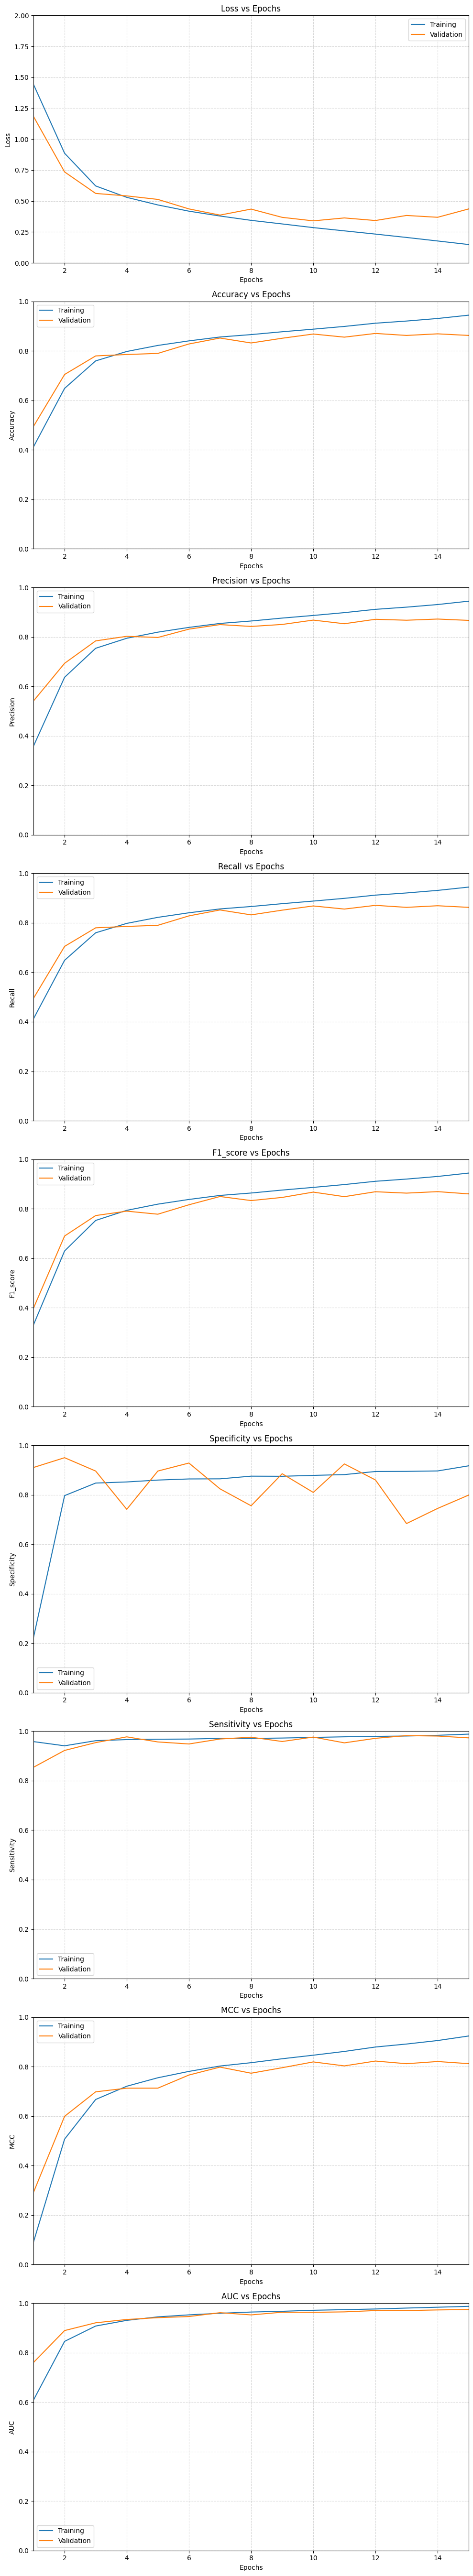

In [26]:
def plot_metrics(train_metrics_history, val_metrics_history, metric_names):
    """
    Plots the given metrics for the training and validation sets.

    Args:
        train_metrics_history: a dictionary containing training metrics history
        val_metrics_history: a dictionary containing validation metrics history
        metric_names: a list of strings representing the names of the metrics to plot

    Returns:
        None
    """
    num_metrics = len(metric_names)
    num_epochs = len(train_metrics_history[metric_names[0]])

    figure, axes = plt.subplots(num_metrics, figsize=(10, 6 * num_metrics))

    rng = range(1, num_epochs + 1)

    for ax, metric_name in zip(axes, metric_names):
        train_metric = train_metrics_history[metric_name]
        val_metric = val_metrics_history[metric_name]

        ax.plot(rng, train_metric, label="Training")
        ax.plot(rng, val_metric, label="Validation")
        ax.legend()
        ax.set_xlabel("Epochs")

        if metric_name in ("auc", "mcc"):
            ax.set_ylabel(metric_name.upper())
            ax.set_title(metric_name.upper() + " vs Epochs")
        else:
            ax.set_ylabel(metric_name.capitalize())
            ax.set_title(metric_name.capitalize() + " vs Epochs")

        max_metric = max(max(train_metric), max(val_metric))
        min_metric = min(min(train_metric), min(val_metric))
        y_max = math.ceil(max_metric)

        if min_metric > 0 or max_metric > 1:
            ax.set_ylim(0, y_max)
        else:
            ax.set_ylim(min_metric, y_max)

        ax.grid(True, linestyle='--', alpha=0.5)
        ax.set_xlim(1, num_epochs)

    plt.tight_layout()
    plt.show()

plot_metrics(train_metrics_history, val_metrics_history, metric_names)

In [27]:
model.eval()
total_loss = 0.0
all_predictions = []
all_targets = []

with torch.no_grad():
    for batch_idx, (data, targets) in enumerate(tqdm(test_loader, desc="Testing Model")):
        data = data.to(device)
        targets = targets.to(device)

        outputs = model(data)
        loss = criterion(outputs, targets)
        total_loss += loss.item()

        all_predictions.extend(outputs.detach().cpu().numpy())
        all_targets.extend(targets.detach().cpu().numpy())

all_predictions = np.array(all_predictions)
all_targets = np.array(all_targets)

average_loss = total_loss / len(test_loader)
test_metrics = custom_metrics(torch.tensor(all_predictions), torch.tensor(all_targets), average_loss)

testing_metrics_line = "Metrics - "
for metric_name, metric_value in test_metrics.items():
    if metric_name == 'auc':
        testing_metrics_line += f"{metric_name}: {metric_value:.4f}"
    else:
        testing_metrics_line += f"{metric_name}: {metric_value:.4f}, "

print(f"{testing_metrics_line}")

Testing Model: 100%|██████████| 155/155 [00:11<00:00, 13.51it/s]

Metrics - loss: 0.3374, accuracy: 0.8759, precision: 0.8762, recall: 0.8759, f1_score: 0.8760, specificity: 0.8273, sensitivity: 0.9799, mcc: 0.8301, auc: 0.9643


In [28]:
true_labels = np.array(all_targets)

predicted_labels = np.argmax(np.array(all_predictions), axis=1)

true_labels = true_labels.astype(int)
predicted_labels = predicted_labels.astype(int)

report = classification_report(true_labels, predicted_labels, target_names=classes, digits=4)

accuracy = accuracy_score(true_labels, predicted_labels)
num_errors = np.sum(true_labels != predicted_labels)

print(report)
print(f'There were {num_errors} errors in {len(predicted_labels)} tests for an accuracy of {accuracy*100:6.2f}')

                     precision    recall  f1-score   support

Bacterial Pneumonia     0.8394    0.8273    0.8333       278
              COVID     0.9022    0.8923    0.8972       362
       Lung_Opacity     0.8731    0.8586    0.8658       601
             Normal     0.9043    0.9176    0.9109      1019
       Tuberculosis     0.9559    0.9286    0.9420        70
    Viral Pneumonia     0.6429    0.6667    0.6545       135

           accuracy                         0.8759      2465
          macro avg     0.8530    0.8485    0.8506      2465
       weighted avg     0.8762    0.8759    0.8760      2465

There were 306 errors in 2465 tests for an accuracy of  87.59


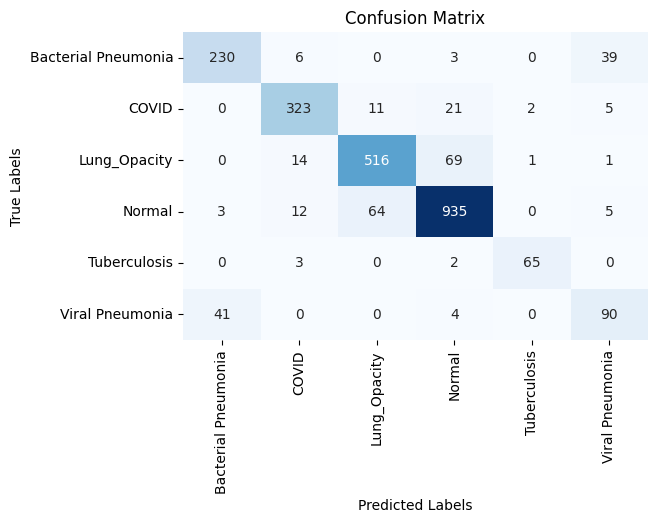

In [29]:
confusion_matrix = torch.zeros(num_classes, num_classes)
for t, p in zip(true_labels, predicted_labels):
    confusion_matrix[t, p] += 1

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues', cbar=False,
            xticklabels=classes, yticklabels=classes)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()